# Task 4: Modeling

## Overview
This notebook implements comprehensive machine learning models to predict Remaining Useful Life (RUL) of aircraft engines using the engineered features from the previous tasks. We follow a structured approach with baseline models, advanced algorithms, and ensemble methods.

## Modeling Phases
1. **Phase 4.1**: Modeling Setup and Data Preparation
2. **Phase 4.2**: Baseline Model Development
3. **Phase 4.3**: Advanced Model Development
4. **Phase 4.4**: Model Optimization and Selection
5. **Phase 4.5**: Model Interpretation and Analysis
6. **Phase 4.6**: Final Model Export

## Phase 4.1: Modeling Setup and Data Preparation

**Objective**: Set up the modeling environment and prepare data for machine learning

### Step 4.1.1: Environment Setup and Library Import

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
import warnings
from datetime import datetime
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2
CROSS_VAL_FOLDS = 5

print("Environment setup complete!")
print(f"Random state set to: {RANDOM_STATE}")
print(f"All required libraries imported successfully!")

Environment setup complete!
Random state set to: 42
All required libraries imported successfully!


In [2]:
# Define data paths
DATA_PATH = Path('../source_data')
INTERMEDIATE_DATA_PATH = Path('../intermediate_data')
RESULTS_DATA_PATH = Path('../results_data')
MODELS_PATH = RESULTS_DATA_PATH / 'trained_models'

# Create directories if they don't exist
RESULTS_DATA_PATH.mkdir(exist_ok=True)
MODELS_PATH.mkdir(exist_ok=True)

# PHM Challenge Scoring Function
def phm_score(y_true, y_pred):
    """
    Calculate PHM Challenge scoring function.
    Asymmetric scoring that penalizes late predictions more than early ones.
    """
    errors = y_pred - y_true
    score = 0
    
    for error in errors:
        if error < 0:  # Early prediction (negative error)
            score += np.exp(-error / 13) - 1
        else:  # Late prediction (positive error)
            score += np.exp(error / 10) - 1
    
    return score

print(f"Data paths configured:")
print(f"- Intermediate data: {INTERMEDIATE_DATA_PATH}")
print(f"- Results data: {RESULTS_DATA_PATH}")
print(f"- Models: {MODELS_PATH}")

Data paths configured:
- Intermediate data: ../intermediate_data
- Results data: ../results_data
- Models: ../results_data/trained_models


### Step 4.1.2: Data Loading and Initial Setup

In [3]:
# Load engineered features
train_features_path = INTERMEDIATE_DATA_PATH / 'feature_engineering_train_features.csv'
test_features_path = INTERMEDIATE_DATA_PATH / 'feature_engineering_test_features.csv'

# Load training data
train_data = pd.read_csv(train_features_path)
print(f"Training data loaded: {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")

# Load test data
test_data = pd.read_csv(test_features_path)
print(f"\nTest data loaded: {test_data.shape}")
print(f"Columns: {list(test_data.columns)}")

# Display data info
print("\nTraining data info:")
print(train_data.info())
print("\nFirst few rows:")
print(train_data.head())

Training data loaded: (20631, 59)
Columns: ['unit_id', 'time_cycles', 'RUL', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_4_cumulative_range', 'sensor_11_cumulative_range', 'time_since_start', 'sensor_7_cumulative_range', 'sensor_4_rolling_mean_3', 'composite_health_index', 'sensor_7_rolling_mean_3', 'sensor_4_to_sensor_7_ratio', 'sensor_3_cumulative_max', 'sensor_11_lag_1', 'sensor_7_sensor_11_diff', 'sensor_11_lag_2', 'sensor_11_health_deviation', 'sensor_3_rolling_mean_3', 'sensor_3_rolling_max_10', 'sensor_11_cumulative_std', 'sensor_11_lag_3', 'sensor_3_cumulative_range', 'sensor_4_lag_1', 'sensor_4_lag_2', 'sensor_11_diff_from_initial', 'sensor_3_rolling_max_5', 'sensor_4_lag_3', 'sensor_4_health_deviation', 'sensor_3_to_sensor_7_ratio', 'sensor_7_lag_1', 'sensor_4_cumulative_std', 'sensor_3_rolling_min_5', 'sensor_7_lag_2', 'sensor_3_rolling_max_3', 'sensor_3_rolling_min_10', 'sensor_7_lag_3', 'sensor_7_

### Step 4.1.3: Train/Validation/Test Split

In [4]:
# Separate features and target
feature_cols = [col for col in train_data.columns if col not in ['unit_id', 'time_cycles', 'RUL']]
X_train_full = train_data[feature_cols]
y_train_full = train_data['RUL']

# Test set features (no RUL column in test data)
X_test = test_data[feature_cols]

# Split training data into train and validation sets
# Use stratified split based on RUL ranges to ensure balanced distribution
rul_bins = pd.cut(y_train_full, bins=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=rul_bins
)

print(f"Data split completed:")
print(f"- Training set: {X_train.shape[0]} samples")
print(f"- Validation set: {X_val.shape[0]} samples")
print(f"- Test set: {X_test.shape[0]} samples")
print(f"- Number of features: {X_train.shape[1]}")

# Display RUL distribution across splits
print(f"\nRUL distribution:")
print(f"- Training: min={y_train.min():.1f}, max={y_train.max():.1f}, mean={y_train.mean():.1f}")
print(f"- Validation: min={y_val.min():.1f}, max={y_val.max():.1f}, mean={y_val.mean():.1f}")

Data split completed:
- Training set: 16504 samples
- Validation set: 4127 samples
- Test set: 13096 samples
- Number of features: 56

RUL distribution:
- Training: min=1.0, max=362.0, mean=108.8
- Validation: min=1.0, max=358.0, mean=108.8


### Step 4.1.4: Feature Scaling and Preparation

In [5]:
# Check for missing values before scaling
print("Checking for missing values in features...")
print(f"Training features missing values: {X_train.isnull().sum().sum()}")
print(f"Validation features missing values: {X_val.isnull().sum().sum()}")
print(f"Test features missing values: {X_test.isnull().sum().sum()}")

# Check for infinite values
print(f"\nChecking for infinite values...")
print(f"Training features infinite values: {np.isinf(X_train.values).sum()}")
print(f"Validation features infinite values: {np.isinf(X_val.values).sum()}")
print(f"Test features infinite values: {np.isinf(X_test.values).sum()}")

# Handle any missing or infinite values
if X_train.isnull().sum().sum() > 0 or np.isinf(X_train.values).sum() > 0:
    print("\nHandling missing/infinite values...")
    # Replace infinite values with NaN first
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_val = X_val.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    
    # Fill missing values with column medians
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train), 
        columns=X_train.columns, 
        index=X_train.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val), 
        columns=X_val.columns, 
        index=X_val.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test), 
        columns=X_test.columns, 
        index=X_test.index
    )
    
    # Update the original DataFrames
    X_train = X_train_imputed
    X_val = X_val_imputed
    X_test = X_test_imputed
    
    print("✓ Missing/infinite values handled with median imputation")

# Initialize scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Fit scalers on training data
X_train_scaled = scaler_standard.fit_transform(X_train)
X_val_scaled = scaler_standard.transform(X_val)
X_test_scaled = scaler_standard.transform(X_test)

# Also prepare MinMax scaled versions for neural networks
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)
X_test_minmax = scaler_minmax.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

X_train_minmax = pd.DataFrame(X_train_minmax, columns=feature_cols, index=X_train.index)
X_val_minmax = pd.DataFrame(X_val_minmax, columns=feature_cols, index=X_val.index)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=feature_cols, index=X_test.index)

# Final check for NaN values after scaling
print(f"\nFinal check after scaling:")
print(f"Training scaled features NaN: {X_train_scaled.isnull().sum().sum()}")
print(f"Validation scaled features NaN: {X_val_scaled.isnull().sum().sum()}")
print(f"Test scaled features NaN: {X_test_scaled.isnull().sum().sum()}")

print("\nFeature scaling completed:")
print(f"- StandardScaler applied for most models")
print(f"- MinMaxScaler applied for neural networks")
print(f"- Scaled feature shape: {X_train_scaled.shape}")
print(f"- No missing values: {X_train_scaled.isnull().sum().sum() == 0}")
print(f"- No infinite values: {np.isinf(X_train_scaled.values).sum() == 0}")
print(f"- Feature range after StandardScaler: [{X_train_scaled.values.min():.2f}, {X_train_scaled.values.max():.2f}]")
print(f"- Feature range after MinMaxScaler: [{X_train_minmax.values.min():.2f}, {X_train_minmax.values.max():.2f}]")

Checking for missing values in features...
Training features missing values: 1892
Validation features missing values: 508
Test features missing values: 2400

Checking for infinite values...
Training features infinite values: 0
Validation features infinite values: 0
Test features infinite values: 0

Handling missing/infinite values...
✓ Missing/infinite values handled with median imputation

Final check after scaling:
Training scaled features NaN: 0
Validation scaled features NaN: 0
Test scaled features NaN: 0

Feature scaling completed:
- StandardScaler applied for most models
- MinMaxScaler applied for neural networks
- Scaled feature shape: (16504, 56)
- No missing values: True
- No infinite values: True
- Feature range after StandardScaler: [-5.70, 11.09]
- Feature range after MinMaxScaler: [0.00, 1.00]


In [6]:
# Import SimpleImputer for data cleaning
from sklearn.impute import SimpleImputer

# Define comprehensive evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive evaluation metrics for regression models.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    phm = phm_score(y_true, y_pred)
    
    metrics = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'PHM_Score': phm
    }
    
    return metrics

# Initialize results storage
model_results = []
model_predictions = {}
trained_models = {}

print("Evaluation framework ready!")
print("Metrics to track: RMSE, MAE, R², MAPE, PHM Score")

Evaluation framework ready!
Metrics to track: RMSE, MAE, R², MAPE, PHM Score


## Phase 4.2: Baseline Model Development

**Objective**: Develop and evaluate baseline regression models

### Step 4.2.1: Linear Regression Models

In [7]:
# Linear Regression
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)
metrics_lr = evaluate_model(y_val, y_pred_lr, "Linear Regression")
model_results.append(metrics_lr)
model_predictions['Linear Regression'] = y_pred_lr
trained_models['Linear Regression'] = lr

# Ridge Regression
print("Training Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_val_scaled)
metrics_ridge = evaluate_model(y_val, y_pred_ridge, "Ridge Regression")
model_results.append(metrics_ridge)
model_predictions['Ridge Regression'] = y_pred_ridge
trained_models['Ridge Regression'] = ridge

# Lasso Regression
print("Training Lasso Regression...")
lasso = Lasso(alpha=1.0, random_state=RANDOM_STATE)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_val_scaled)
metrics_lasso = evaluate_model(y_val, y_pred_lasso, "Lasso Regression")
model_results.append(metrics_lasso)
model_predictions['Lasso Regression'] = y_pred_lasso
trained_models['Lasso Regression'] = lasso

print("\nLinear models completed!")
print(f"Linear Regression - RMSE: {metrics_lr['RMSE']:.2f}, R²: {metrics_lr['R²']:.3f}")
print(f"Ridge Regression - RMSE: {metrics_ridge['RMSE']:.2f}, R²: {metrics_ridge['R²']:.3f}")
print(f"Lasso Regression - RMSE: {metrics_lasso['RMSE']:.2f}, R²: {metrics_lasso['R²']:.3f}")

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...

Linear models completed!
Linear Regression - RMSE: 35.06, R²: 0.740
Ridge Regression - RMSE: 35.21, R²: 0.738
Lasso Regression - RMSE: 36.21, R²: 0.723


### Step 4.2.2: Random Forest Baseline

In [8]:
# Random Forest with hyperparameter tuning
print("Training Random Forest with hyperparameter tuning...")

# Define parameter grid for RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# RandomizedSearchCV for efficient hyperparameter search
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf, rf_param_grid, 
    n_iter=20, 
    cv=3,  # Reduced CV folds for faster training
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search
rf_search.fit(X_train, y_train)  # Use unscaled data for tree-based models

# Get best model and predictions
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_val)
metrics_rf = evaluate_model(y_val, y_pred_rf, "Random Forest")
model_results.append(metrics_rf)
model_predictions['Random Forest'] = y_pred_rf
trained_models['Random Forest'] = best_rf

print(f"Random Forest - RMSE: {metrics_rf['RMSE']:.2f}, R²: {metrics_rf['R²']:.3f}")
print(f"Best parameters: {rf_search.best_params_}")

Training Random Forest with hyperparameter tuning...
Random Forest - RMSE: 10.37, R²: 0.977
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}


### Step 4.2.3: Baseline Model Comparison

Baseline Model Performance Summary:
               Model    RMSE     MAE     R²    MAPE    PHM_Score
0  Linear Regression  35.060  25.550  0.740  59.003  2342747.658
1   Ridge Regression  35.214  25.714  0.738  62.701  2261206.612
2   Lasso Regression  36.213  26.822  0.723  62.453  3413756.112
3      Random Forest  10.368   5.642  0.977   9.110    20694.696


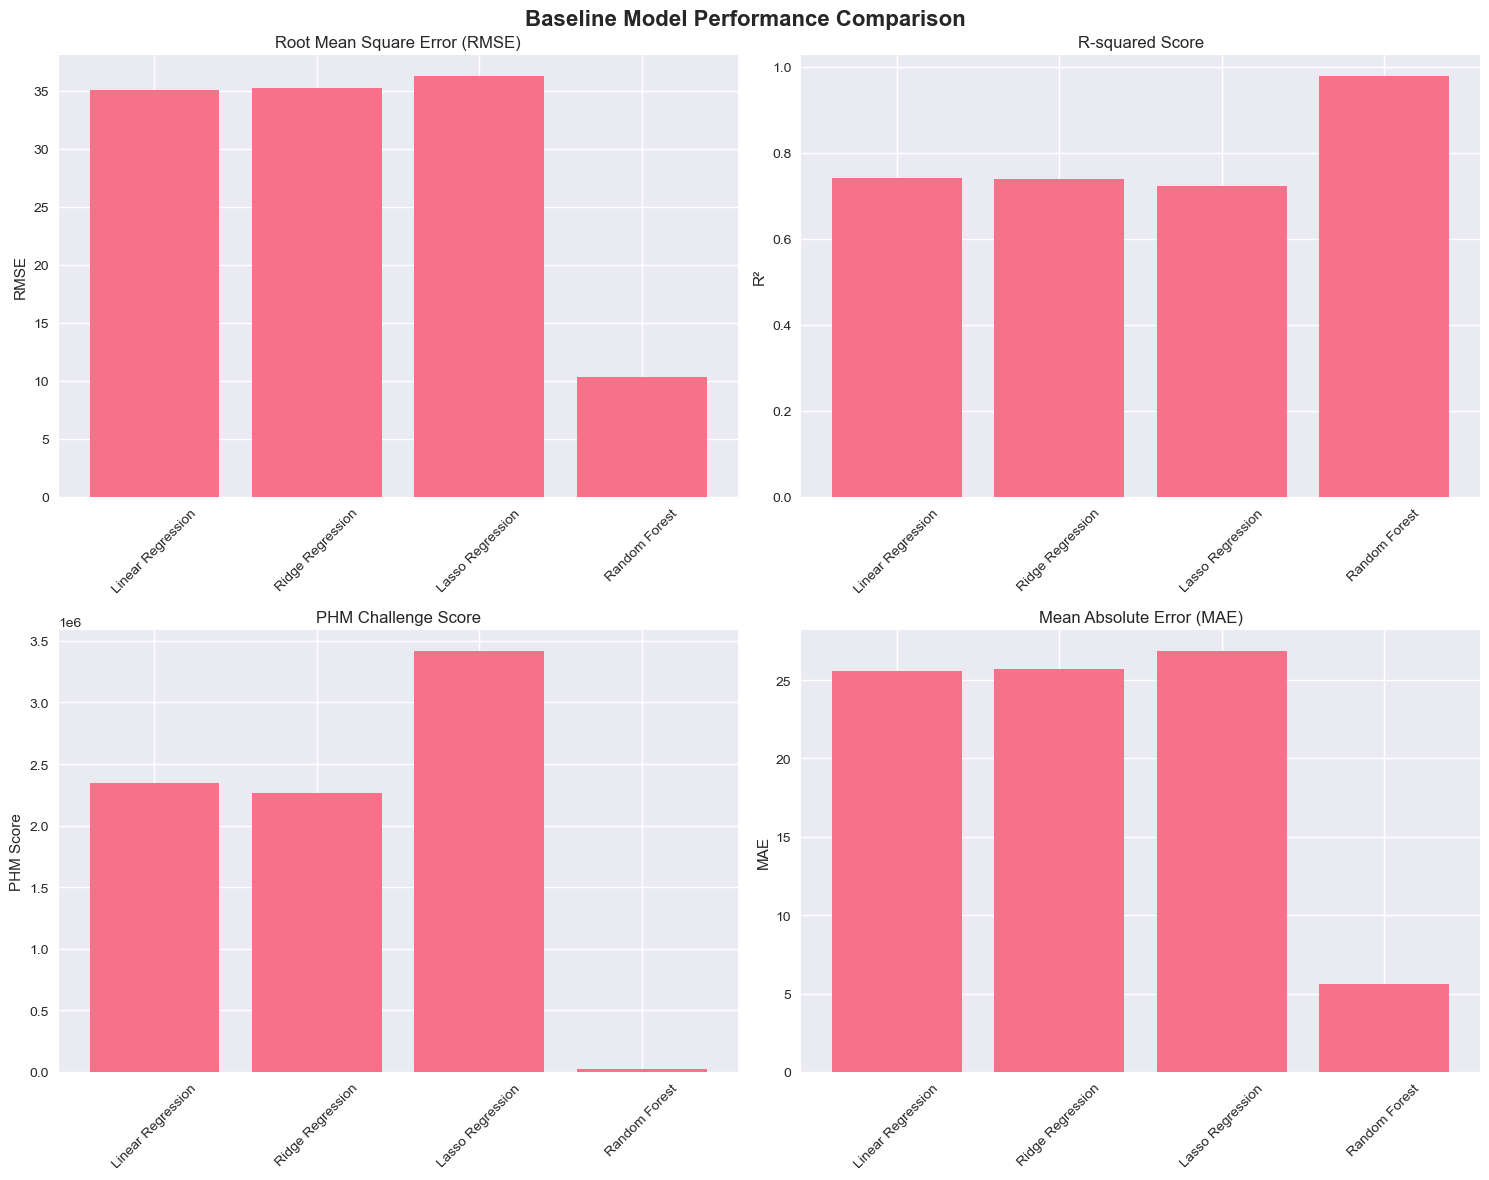


Best baseline model: Random Forest with RMSE: 10.37


In [9]:
# Create baseline results summary
baseline_results_df = pd.DataFrame(model_results)
print("Baseline Model Performance Summary:")
print(baseline_results_df.round(3))

# Visualize baseline model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Baseline Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
axes[0, 0].bar(baseline_results_df['Model'], baseline_results_df['RMSE'])
axes[0, 0].set_title('Root Mean Square Error (RMSE)')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# R² comparison
axes[0, 1].bar(baseline_results_df['Model'], baseline_results_df['R²'])
axes[0, 1].set_title('R-squared Score')
axes[0, 1].set_ylabel('R²')
axes[0, 1].tick_params(axis='x', rotation=45)

# PHM Score comparison
axes[1, 0].bar(baseline_results_df['Model'], baseline_results_df['PHM_Score'])
axes[1, 0].set_title('PHM Challenge Score')
axes[1, 0].set_ylabel('PHM Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1, 1].bar(baseline_results_df['Model'], baseline_results_df['MAE'])
axes[1, 1].set_title('Mean Absolute Error (MAE)')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find best baseline model
best_baseline_idx = baseline_results_df['RMSE'].idxmin()
best_baseline = baseline_results_df.iloc[best_baseline_idx]
print(f"\nBest baseline model: {best_baseline['Model']} with RMSE: {best_baseline['RMSE']:.2f}")

## Phase 4.3: Advanced Model Development

**Objective**: Implement advanced machine learning algorithms for improved performance

### Step 4.3.1: XGBoost Implementation

In [10]:
# XGBoost with hyperparameter tuning
print("Training XGBoost...")

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost model
xgb_model = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
xgb_search = RandomizedSearchCV(
    xgb_model, xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search
xgb_search.fit(X_train, y_train)

# Get best model and predictions
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
metrics_xgb = evaluate_model(y_val, y_pred_xgb, "XGBoost")
model_results.append(metrics_xgb)
model_predictions['XGBoost'] = y_pred_xgb
trained_models['XGBoost'] = best_xgb

print(f"XGBoost - RMSE: {metrics_xgb['RMSE']:.2f}, R²: {metrics_xgb['R²']:.3f}")
print(f"Best parameters: {xgb_search.best_params_}")

Training XGBoost...
XGBoost - RMSE: 9.38, R²: 0.981
Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### Step 4.3.2: LightGBM Implementation

In [11]:
# LightGBM
print("Training LightGBM...")

# LightGBM parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 0.9, 1.0]
}

# LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgb_search = RandomizedSearchCV(
    lgb_model, lgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search
lgb_search.fit(X_train, y_train)

# Get best model and predictions
best_lgb = lgb_search.best_estimator_
y_pred_lgb = best_lgb.predict(X_val)
metrics_lgb = evaluate_model(y_val, y_pred_lgb, "LightGBM")
model_results.append(metrics_lgb)
model_predictions['LightGBM'] = y_pred_lgb
trained_models['LightGBM'] = best_lgb

print(f"LightGBM - RMSE: {metrics_lgb['RMSE']:.2f}, R²: {metrics_lgb['R²']:.3f}")
print(f"Best parameters: {lgb_search.best_params_}")

Training LightGBM...
LightGBM - RMSE: 9.78, R²: 0.980
Best parameters: {'subsample': 1.0, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1}


### Step 4.3.3: Neural Network (MLP) Implementation

In [12]:
# Multi-Layer Perceptron (Neural Network)
print("Training Neural Network (MLP)...")

# MLP parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

# MLP model (using MinMax scaled data)
mlp_model = MLPRegressor(random_state=RANDOM_STATE, early_stopping=True, validation_fraction=0.1)
mlp_search = RandomizedSearchCV(
    mlp_model, mlp_param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search using MinMax scaled data
mlp_search.fit(X_train_minmax, y_train)

# Get best model and predictions
best_mlp = mlp_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_val_minmax)
metrics_mlp = evaluate_model(y_val, y_pred_mlp, "Neural Network")
model_results.append(metrics_mlp)
model_predictions['Neural Network'] = y_pred_mlp
trained_models['Neural Network'] = best_mlp

print(f"Neural Network - RMSE: {metrics_mlp['RMSE']:.2f}, R²: {metrics_mlp['R²']:.3f}")
print(f"Best parameters: {mlp_search.best_params_}")

Training Neural Network (MLP)...


/Users/vilcek/anaconda3/envs/CMAPSS_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vilcek/anaconda3/envs/CMAPSS_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network - RMSE: 24.49, R²: 0.873
Best parameters: {'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.01, 'activation': 'relu'}


### Step 4.3.4: Gradient Boosting Implementation

In [13]:
# Gradient Boosting Regressor
print("Training Gradient Boosting...")

# Gradient Boosting parameter grid
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_search = RandomizedSearchCV(
    gb_model, gb_param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search
gb_search.fit(X_train, y_train)

# Get best model and predictions
best_gb = gb_search.best_estimator_
y_pred_gb = best_gb.predict(X_val)
metrics_gb = evaluate_model(y_val, y_pred_gb, "Gradient Boosting")
model_results.append(metrics_gb)
model_predictions['Gradient Boosting'] = y_pred_gb
trained_models['Gradient Boosting'] = best_gb

print(f"Gradient Boosting - RMSE: {metrics_gb['RMSE']:.2f}, R²: {metrics_gb['R²']:.3f}")
print(f"Best parameters: {gb_search.best_params_}")

Training Gradient Boosting...
Gradient Boosting - RMSE: 10.34, R²: 0.977
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


## Phase 4.4: Model Optimization and Selection

**Objective**: Compare all models and implement ensemble methods

### Step 4.4.1: Comprehensive Model Comparison

All Models Performance Summary:
               Model    RMSE     MAE     R²    MAPE    PHM_Score
0  Linear Regression  35.060  25.550  0.740  59.003  2342747.658
1   Ridge Regression  35.214  25.714  0.738  62.701  2261206.612
2   Lasso Regression  36.213  26.822  0.723  62.453  3413756.112
3      Random Forest  10.368   5.642  0.977   9.110    20694.696
4            XGBoost   9.382   5.252  0.981   7.410    31299.396
5           LightGBM   9.782   5.841  0.980   8.135    12053.260
6     Neural Network  24.488  15.760  0.873  17.767   752185.096
7  Gradient Boosting  10.339   6.310  0.977   8.816    24692.270

Ranked by RMSE (best to worst):
               Model    RMSE     R²    PHM_Score
4            XGBoost   9.382  0.981    31299.396
5           LightGBM   9.782  0.980    12053.260
7  Gradient Boosting  10.339  0.977    24692.270
3      Random Forest  10.368  0.977    20694.696
6     Neural Network  24.488  0.873   752185.096
0  Linear Regression  35.060  0.740  2342747.658
1   Rid

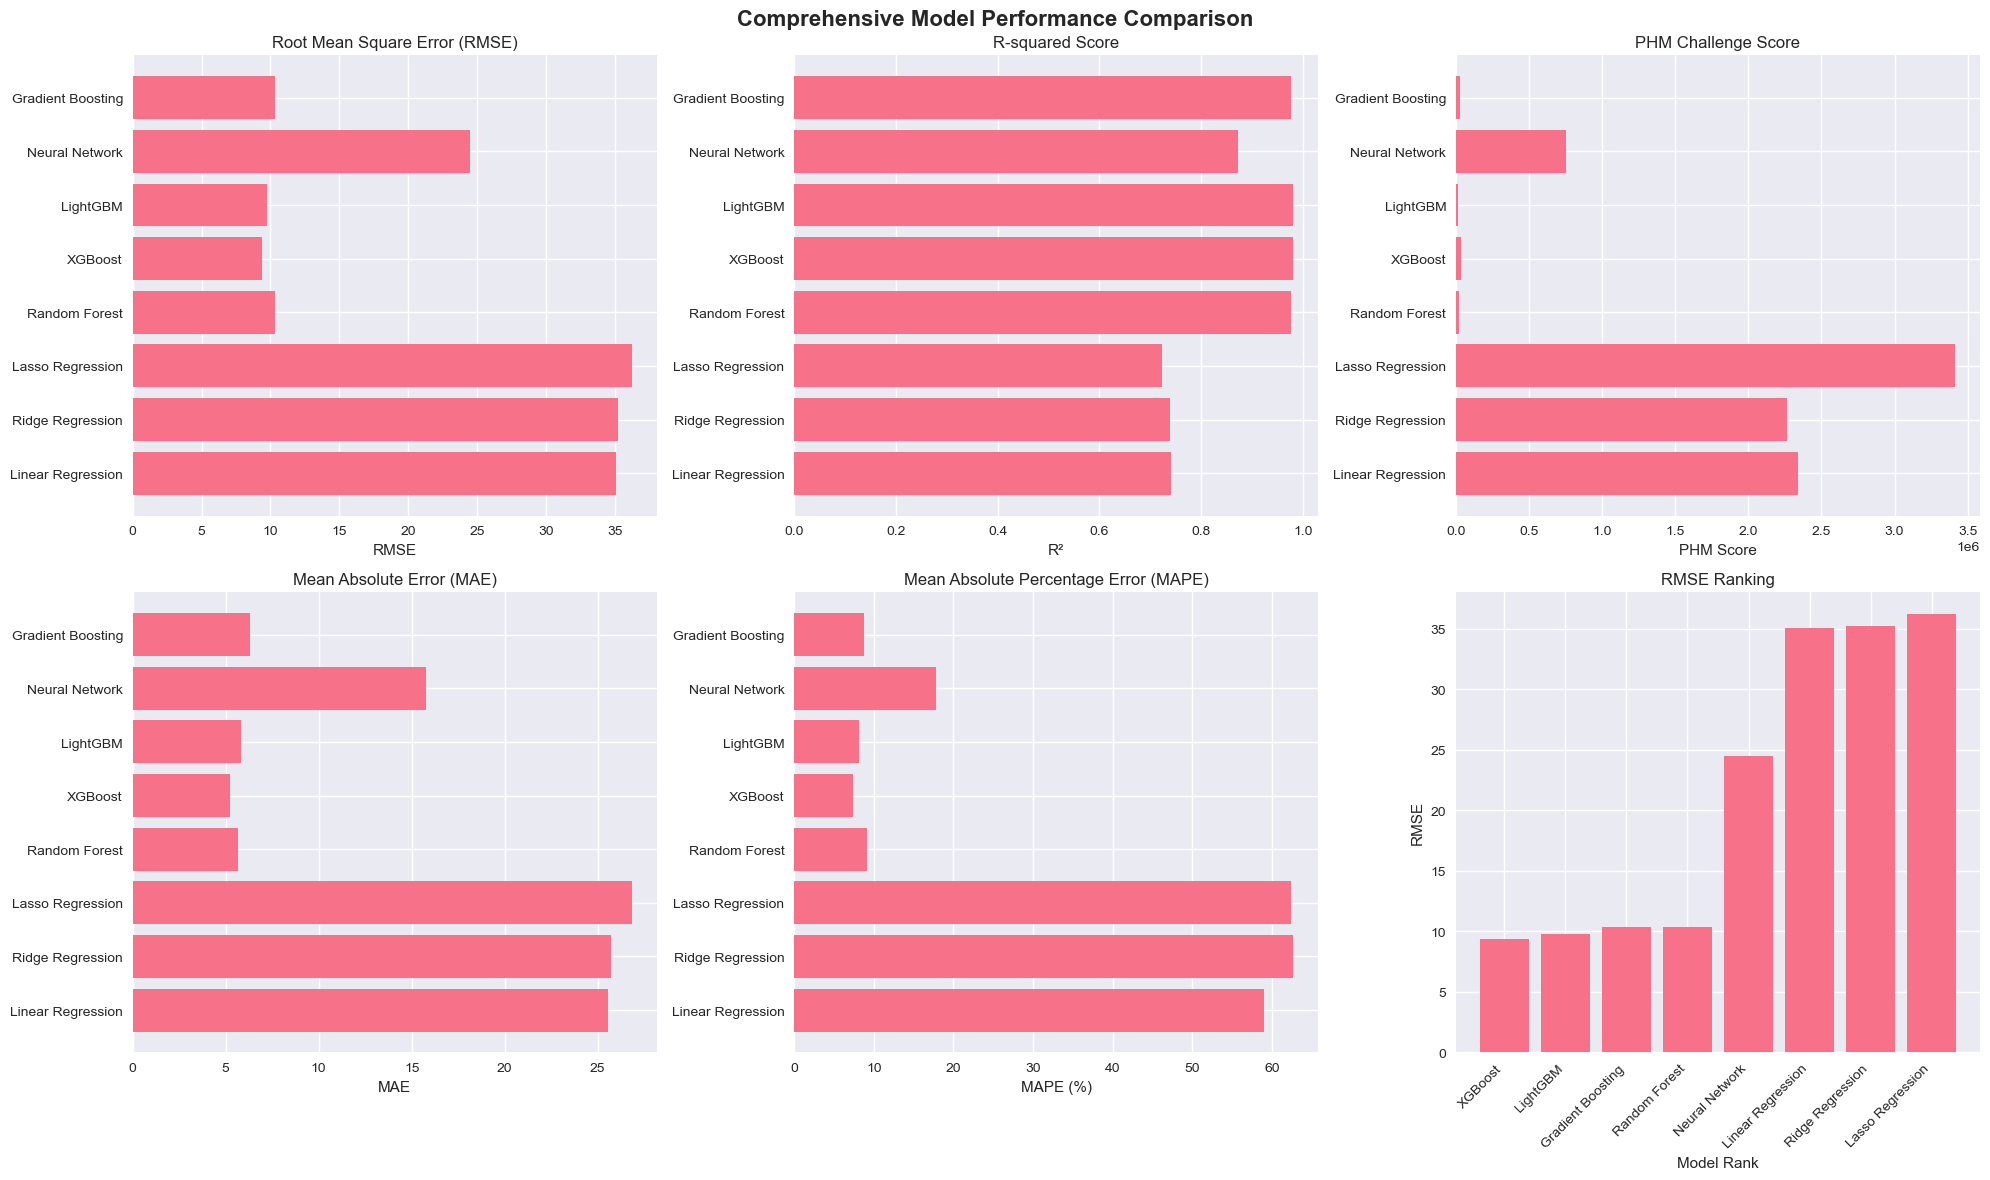

In [14]:
# Create comprehensive results summary
all_results_df = pd.DataFrame(model_results)
print("All Models Performance Summary:")
print(all_results_df.round(3))

# Sort by RMSE (lower is better)
all_results_sorted = all_results_df.sort_values('RMSE')
print("\nRanked by RMSE (best to worst):")
print(all_results_sorted[['Model', 'RMSE', 'R²', 'PHM_Score']].round(3))

# Visualize comprehensive model comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

# RMSE comparison
axes[0, 0].barh(all_results_df['Model'], all_results_df['RMSE'])
axes[0, 0].set_title('Root Mean Square Error (RMSE)')
axes[0, 0].set_xlabel('RMSE')

# R² comparison
axes[0, 1].barh(all_results_df['Model'], all_results_df['R²'])
axes[0, 1].set_title('R-squared Score')
axes[0, 1].set_xlabel('R²')

# PHM Score comparison
axes[0, 2].barh(all_results_df['Model'], all_results_df['PHM_Score'])
axes[0, 2].set_title('PHM Challenge Score')
axes[0, 2].set_xlabel('PHM Score')

# MAE comparison
axes[1, 0].barh(all_results_df['Model'], all_results_df['MAE'])
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_xlabel('MAE')

# MAPE comparison
axes[1, 1].barh(all_results_df['Model'], all_results_df['MAPE'])
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_xlabel('MAPE (%)')

# Model ranking visualization
ranking_scores = all_results_sorted.reset_index(drop=True)
axes[1, 2].bar(range(len(ranking_scores)), ranking_scores['RMSE'])
axes[1, 2].set_title('RMSE Ranking')
axes[1, 2].set_xlabel('Model Rank')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].set_xticks(range(len(ranking_scores)))
axes[1, 2].set_xticklabels(ranking_scores['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Step 4.4.2: Ensemble Methods

In [15]:
# Select top performing models for ensemble
top_models = all_results_sorted.head(3)['Model'].tolist()
print(f"Top 3 models for ensemble: {top_models}")

# Voting Ensemble
print("\nCreating Voting Ensemble...")
voting_models = [(name, trained_models[name]) for name in top_models if name != 'Neural Network']

# Add Neural Network with appropriate scaler
if 'Neural Network' in top_models:
    voting_models.append(('Neural Network', trained_models['Neural Network']))

voting_ensemble = VotingRegressor(voting_models)

# For voting ensemble, we need to handle different scaling requirements
# Use standard scaled data for most models
voting_ensemble.fit(X_train_scaled, y_train)
y_pred_voting = voting_ensemble.predict(X_val_scaled)
metrics_voting = evaluate_model(y_val, y_pred_voting, "Voting Ensemble")
model_results.append(metrics_voting)
model_predictions['Voting Ensemble'] = y_pred_voting
trained_models['Voting Ensemble'] = voting_ensemble

print(f"Voting Ensemble - RMSE: {metrics_voting['RMSE']:.2f}, R²: {metrics_voting['R²']:.3f}")

# Weighted Ensemble
print("\nCreating Weighted Ensemble...")
# Calculate weights based on inverse RMSE (better models get higher weights)
top_3_results = all_results_sorted.head(3)
rmse_values = top_3_results['RMSE'].values
weights = 1 / rmse_values
weights = weights / weights.sum()  # Normalize weights

print(f"Ensemble weights: {dict(zip(top_3_results['Model'], weights.round(3)))}")

# Create weighted predictions - initialize with proper dtype
weighted_pred = np.zeros(len(y_val), dtype=np.float64)
for i, model_name in enumerate(top_3_results['Model']):
    if model_name == 'Neural Network':
        pred = trained_models[model_name].predict(X_val_minmax)
    else:
        pred = trained_models[model_name].predict(X_val)
    
    # Ensure prediction array is float64
    pred = np.asarray(pred, dtype=np.float64)
    weighted_pred += weights[i] * pred

metrics_weighted = evaluate_model(y_val, weighted_pred, "Weighted Ensemble")
model_results.append(metrics_weighted)
model_predictions['Weighted Ensemble'] = weighted_pred

# Note: Weighted Ensemble doesn't have a single model object, it's a meta-predictor
# We'll handle it separately in prediction logic

print(f"Weighted Ensemble - RMSE: {metrics_weighted['RMSE']:.2f}, R²: {metrics_weighted['R²']:.3f}")

Top 3 models for ensemble: ['XGBoost', 'LightGBM', 'Gradient Boosting']

Creating Voting Ensemble...
Voting Ensemble - RMSE: 9.23, R²: 0.982

Creating Weighted Ensemble...
Ensemble weights: {'XGBoost': np.float64(0.349), 'LightGBM': np.float64(0.335), 'Gradient Boosting': np.float64(0.317)}
Weighted Ensemble - RMSE: 9.21, R²: 0.982


### Step 4.4.3: Final Model Selection

In [16]:
# Update results with ensemble methods
final_results_df = pd.DataFrame(model_results)
final_results_sorted = final_results_df.sort_values('RMSE')

print("Final Model Rankings (including ensembles):")
print(final_results_sorted[['Model', 'RMSE', 'R²', 'MAE', 'PHM_Score']].round(3))

# Select best model
best_model_info = final_results_sorted.iloc[0]
best_model_name = best_model_info['Model']

# Handle different types of best models
if best_model_name == 'Weighted Ensemble':
    # Weighted ensemble is a meta-predictor, store the prediction array
    best_model = weighted_pred
    print(f"\n🏆 BEST MODEL: {best_model_name} (Meta-predictor)")
elif best_model_name in trained_models:
    best_model = trained_models[best_model_name]
    print(f"\n🏆 BEST MODEL: {best_model_name}")
else:
    # Fallback - should not happen
    print(f"Warning: Best model {best_model_name} not found in trained_models")
    best_model = None

print(f"Performance:")
print(f"- RMSE: {best_model_info['RMSE']:.2f}")
print(f"- R²: {best_model_info['R²']:.3f}")
print(f"- MAE: {best_model_info['MAE']:.2f}")
print(f"- MAPE: {best_model_info['MAPE']:.2f}%")
print(f"- PHM Score: {best_model_info['PHM_Score']:.2f}")

# Improvement over baseline
baseline_rmse = baseline_results_df['RMSE'].min()
improvement = ((baseline_rmse - best_model_info['RMSE']) / baseline_rmse) * 100
print(f"\nImprovement over baseline: {improvement:.1f}% reduction in RMSE")

Final Model Rankings (including ensembles):
               Model    RMSE     R²     MAE    PHM_Score
9  Weighted Ensemble   9.210  0.982   5.302    13970.270
8    Voting Ensemble   9.225  0.982   5.340    14120.229
4            XGBoost   9.382  0.981   5.252    31299.396
5           LightGBM   9.782  0.980   5.841    12053.260
7  Gradient Boosting  10.339  0.977   6.310    24692.270
3      Random Forest  10.368  0.977   5.642    20694.696
6     Neural Network  24.488  0.873  15.760   752185.096
0  Linear Regression  35.060  0.740  25.550  2342747.658
1   Ridge Regression  35.214  0.738  25.714  2261206.612
2   Lasso Regression  36.213  0.723  26.822  3413756.112

🏆 BEST MODEL: Weighted Ensemble (Meta-predictor)
Performance:
- RMSE: 9.21
- R²: 0.982
- MAE: 5.30
- MAPE: 7.53%
- PHM Score: 13970.27

Improvement over baseline: 11.2% reduction in RMSE


## Phase 4.5: Model Interpretation and Analysis

**Objective**: Analyze model behavior and feature importance

### Step 4.5.1: Feature Importance Analysis

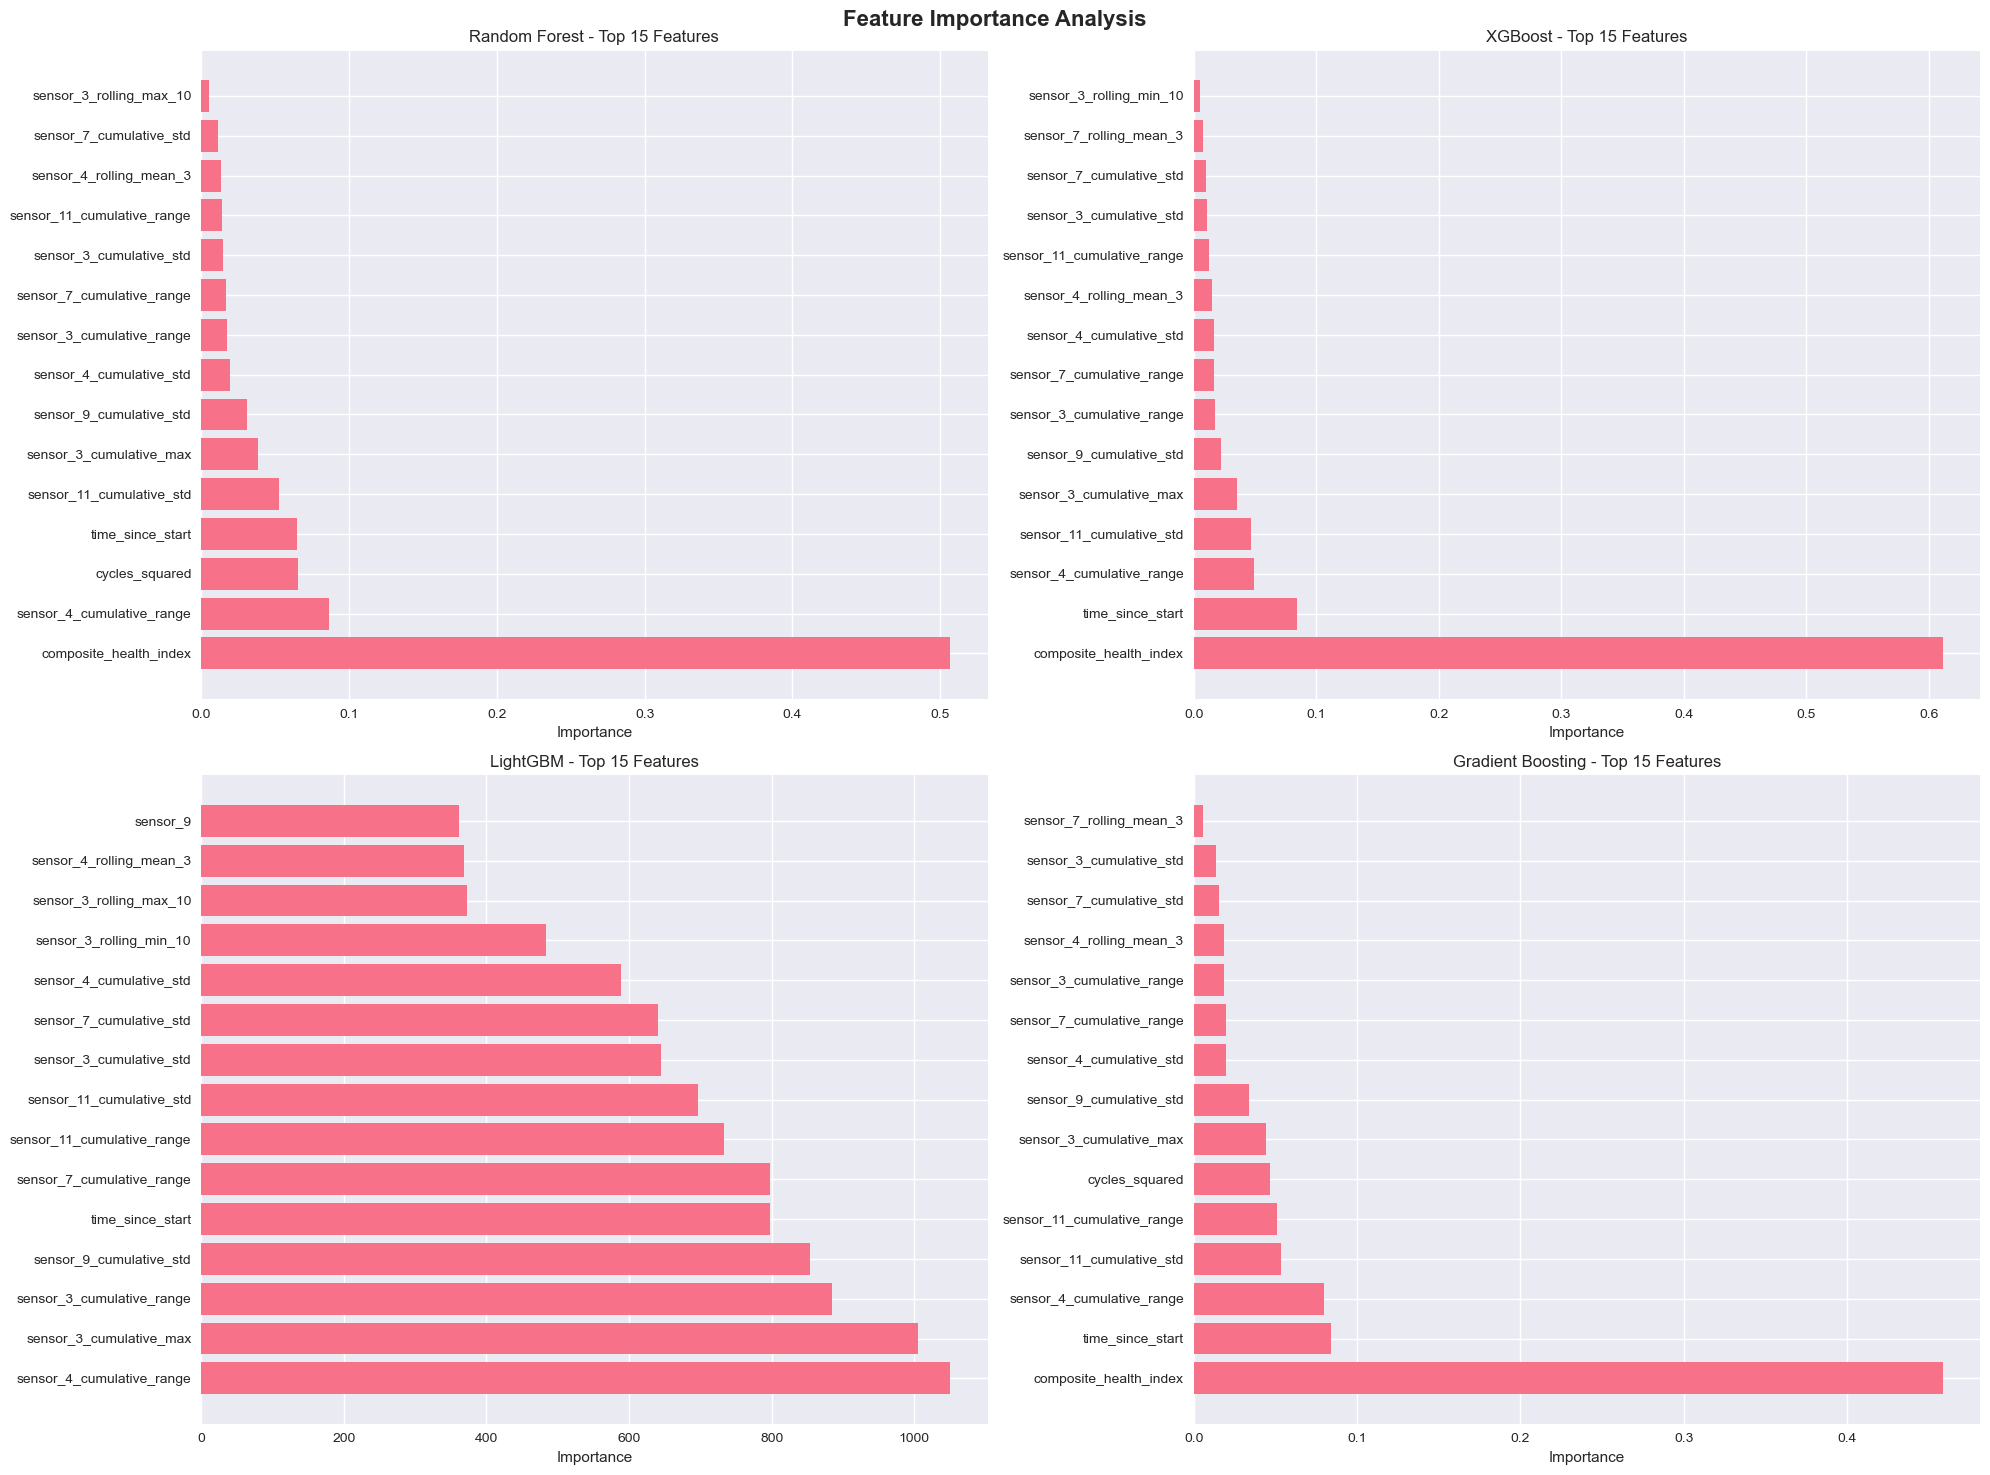


Top 15 Most Important Features (averaged across tree-based models):
                       feature  avg_importance
9    sensor_4_cumulative_range        262.5538
17     sensor_3_cumulative_max        251.2795
26   sensor_3_cumulative_range        221.0134
53     sensor_9_cumulative_std        213.2717
11            time_since_start        199.3082
12   sensor_7_cumulative_range        199.2634
10  sensor_11_cumulative_range        183.2695
24    sensor_11_cumulative_std        174.0381
54     sensor_3_cumulative_std        161.2599
41     sensor_7_cumulative_std        160.0092
35     sensor_4_cumulative_std        147.2640
39     sensor_3_rolling_min_10        121.0034
23     sensor_3_rolling_max_10         93.2540
13     sensor_4_rolling_mean_3         92.2618
3                     sensor_9         90.5022


In [17]:
# Feature importance from tree-based models
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

axes[0, 0].barh(rf_importance.head(15)['feature'], rf_importance.head(15)['importance'])
axes[0, 0].set_title('Random Forest - Top 15 Features')
axes[0, 0].set_xlabel('Importance')

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

axes[0, 1].barh(xgb_importance.head(15)['feature'], xgb_importance.head(15)['importance'])
axes[0, 1].set_title('XGBoost - Top 15 Features')
axes[0, 1].set_xlabel('Importance')

# LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_lgb.feature_importances_
}).sort_values('importance', ascending=False)

axes[1, 0].barh(lgb_importance.head(15)['feature'], lgb_importance.head(15)['importance'])
axes[1, 0].set_title('LightGBM - Top 15 Features')
axes[1, 0].set_xlabel('Importance')

# Gradient Boosting feature importance
gb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_gb.feature_importances_
}).sort_values('importance', ascending=False)

axes[1, 1].barh(gb_importance.head(15)['feature'], gb_importance.head(15)['importance'])
axes[1, 1].set_title('Gradient Boosting - Top 15 Features')
axes[1, 1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Combined feature importance analysis
combined_importance = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': best_rf.feature_importances_,
    'xgb_importance': best_xgb.feature_importances_,
    'lgb_importance': best_lgb.feature_importances_,
    'gb_importance': best_gb.feature_importances_
})

# Calculate average importance
combined_importance['avg_importance'] = combined_importance[[
    'rf_importance', 'xgb_importance', 'lgb_importance', 'gb_importance'
]].mean(axis=1)

combined_importance_sorted = combined_importance.sort_values('avg_importance', ascending=False)
print("\nTop 15 Most Important Features (averaged across tree-based models):")
print(combined_importance_sorted.head(15)[['feature', 'avg_importance']].round(4))

### Step 4.5.2: Model Prediction Analysis

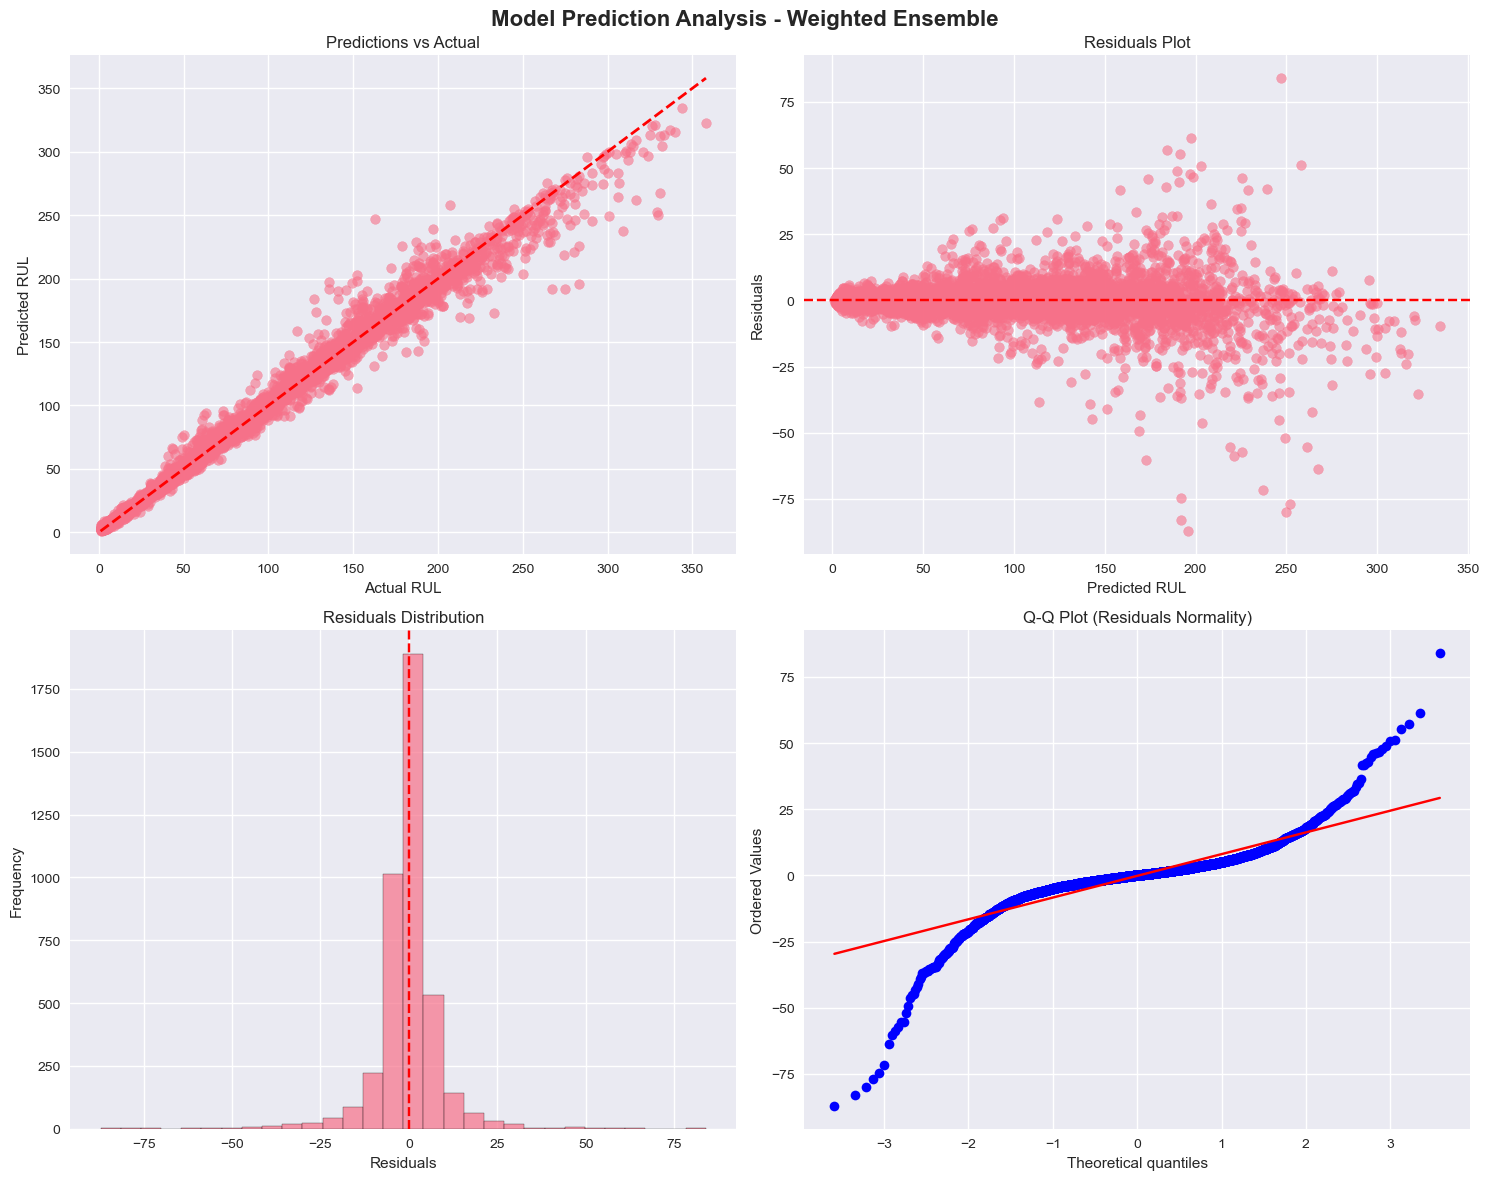


Prediction Analysis for Weighted Ensemble:
- Mean residual: -0.185
- Std residual: 9.209
- Min residual: -87.176
- Max residual: 83.997
- Residuals within ±1 std: 85.1%
- Residuals within ±2 std: 95.1%


In [18]:
# Prediction vs Actual analysis for best model
best_predictions = model_predictions[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Model Prediction Analysis - {best_model_name}', fontsize=16, fontweight='bold')

# Prediction vs Actual scatter plot
axes[0, 0].scatter(y_val, best_predictions, alpha=0.6)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title('Predictions vs Actual')

# Residuals plot
residuals = best_predictions - y_val
axes[0, 1].scatter(best_predictions, residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted RUL')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')

# Residuals distribution
axes[1, 0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution')

# Q-Q plot for residuals normality
from scipy.stats import probplot
probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Residuals Normality)')

plt.tight_layout()
plt.show()

# Calculate prediction statistics
print(f"\nPrediction Analysis for {best_model_name}:")
print(f"- Mean residual: {residuals.mean():.3f}")
print(f"- Std residual: {residuals.std():.3f}")
print(f"- Min residual: {residuals.min():.3f}")
print(f"- Max residual: {residuals.max():.3f}")
print(f"- Residuals within ±1 std: {(np.abs(residuals) <= residuals.std()).mean()*100:.1f}%")
print(f"- Residuals within ±2 std: {(np.abs(residuals) <= 2*residuals.std()).mean()*100:.1f}%")

## Phase 4.6: Final Model Export and Documentation

**Objective**: Save models and create comprehensive documentation

### Step 4.6.1: Model Persistence

In [19]:
# Save all trained models
print("Saving trained models...")

# Save scalers
joblib.dump(scaler_standard, MODELS_PATH / 'scaler_standard.pkl')
joblib.dump(scaler_minmax, MODELS_PATH / 'scaler_minmax.pkl')
print("✓ Scalers saved")

# Save individual models (skip Weighted Ensemble as it's not a single model object)
for model_name, model in trained_models.items():
    if model_name == 'Weighted Ensemble':
        continue  # Skip Weighted Ensemble as it's a meta-predictor
    
    model_filename = f"model_{model_name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, MODELS_PATH / model_filename)
    print(f"✓ {model_name} saved as {model_filename}")

# Save best model separately (handle Weighted Ensemble case)
if best_model_name == 'Weighted Ensemble':
    # For Weighted Ensemble, save the ensemble metadata instead
    ensemble_info = {
        'type': 'weighted_ensemble',
        'top_models': final_results_sorted.head(3)['Model'].tolist(),
        'weights': (1 / final_results_sorted.head(3)['RMSE'].values),
        'requires_minmax_scaling': ['Neural Network'],
        'base_models_path': str(MODELS_PATH)
    }
    # Normalize weights
    ensemble_info['weights'] = ensemble_info['weights'] / ensemble_info['weights'].sum()
    
    import json
    with open(MODELS_PATH / 'best_model_weighted_ensemble.json', 'w') as f:
        json.dump({k: v.tolist() if isinstance(v, np.ndarray) else v 
                  for k, v in ensemble_info.items()}, f, indent=2)
    print(f"✓ Best model (Weighted Ensemble) metadata saved")
else:
    # Save the actual best model
    best_model_filename = "best_model.pkl"
    joblib.dump(trained_models[best_model_name], MODELS_PATH / best_model_filename)
    print(f"✓ Best model ({best_model_name}) saved as {best_model_filename}")

print(f"\nAll models saved to: {MODELS_PATH}")

Saving trained models...
✓ Scalers saved
✓ Linear Regression saved as model_linear_regression.pkl
✓ Ridge Regression saved as model_ridge_regression.pkl
✓ Lasso Regression saved as model_lasso_regression.pkl
✓ Random Forest saved as model_random_forest.pkl
✓ XGBoost saved as model_xgboost.pkl
✓ LightGBM saved as model_lightgbm.pkl
✓ Neural Network saved as model_neural_network.pkl
✓ Gradient Boosting saved as model_gradient_boosting.pkl
✓ Voting Ensemble saved as model_voting_ensemble.pkl
✓ Best model (Weighted Ensemble) metadata saved

All models saved to: ../results_data/trained_models


### Step 4.6.2: Generate Test Predictions

In [20]:
# Generate test predictions using the best model
print(f"Generating test predictions using {best_model_name}...")

if best_model_name == 'Weighted Ensemble':
    # Handle weighted ensemble predictions - use the original non-ensemble models
    # Get the models that were used to create the weighted ensemble
    original_results = all_results_sorted.head(3)  # Use original results before ensembles
    print(f"Using original top 3 models for weighted ensemble:")
    for idx, row in original_results.iterrows():
        print(f"- {row['Model']}: RMSE = {row['RMSE']:.3f}")
    
    # Calculate weights based on inverse RMSE
    rmse_values = original_results['RMSE'].values
    weights = 1 / rmse_values
    weights = weights / weights.sum()
    
    print(f"\nEnsemble weights: {dict(zip(original_results['Model'], weights.round(3)))}")
    
    # Generate weighted predictions
    test_predictions = np.zeros(len(X_test), dtype=np.float64)
    for i, model_name in enumerate(original_results['Model']):
        if model_name == 'Neural Network':
            pred = trained_models[model_name].predict(X_test_minmax)
        else:
            pred = trained_models[model_name].predict(X_test)
        
        # Ensure prediction array is float64
        pred = np.asarray(pred, dtype=np.float64)
        test_predictions += weights[i] * pred
        print(f"Added predictions from {model_name} (weight: {weights[i]:.3f})")
        
elif best_model_name == 'Neural Network':
    # Neural Network requires MinMax scaled data
    test_predictions = trained_models[best_model_name].predict(X_test_minmax)
elif best_model_name == 'Voting Ensemble':
    # Voting ensemble uses standard scaled data
    test_predictions = trained_models[best_model_name].predict(X_test_scaled)
else:
    # All other individual models use unscaled test data
    test_predictions = trained_models[best_model_name].predict(X_test)

# Ensure predictions are float64
test_predictions = np.asarray(test_predictions, dtype=np.float64)

# Create test predictions DataFrame
test_results = pd.DataFrame({
    'unit_id': test_data['unit_id'],
    'predicted_RUL': test_predictions
})

# Save test predictions
test_predictions_path = INTERMEDIATE_DATA_PATH / 'modeling_test_predictions.csv'
test_results.to_csv(test_predictions_path, index=False)

print(f"\nTest predictions saved to: {test_predictions_path}")
print(f"Test predictions shape: {test_results.shape}")
print(f"Predicted RUL range: {test_predictions.min():.1f} - {test_predictions.max():.1f}")
print(f"Mean predicted RUL: {test_predictions.mean():.1f}")

Generating test predictions using Weighted Ensemble...
Using original top 3 models for weighted ensemble:
- XGBoost: RMSE = 9.382
- LightGBM: RMSE = 9.782
- Gradient Boosting: RMSE = 10.339

Ensemble weights: {'XGBoost': np.float64(0.349), 'LightGBM': np.float64(0.335), 'Gradient Boosting': np.float64(0.317)}
Added predictions from XGBoost (weight: 0.349)
Added predictions from LightGBM (weight: 0.335)
Added predictions from Gradient Boosting (weight: 0.317)

Test predictions saved to: ../intermediate_data/modeling_test_predictions.csv
Test predictions shape: (13096, 2)
Predicted RUL range: 3.5 - 291.1
Mean predicted RUL: 136.9


In [21]:
# Create comprehensive modeling metadata
modeling_metadata = {
    'task_info': {
        'task_name': 'modeling',
        'task_number': 4,
        'description': 'Machine learning model development for RUL prediction',
        'timestamp': datetime.now().isoformat(),
        'random_state': RANDOM_STATE
    },
    'data_info': {
        'training_samples': len(X_train),
        'validation_samples': len(X_val),
        'test_samples': len(X_test),
        'num_features': len(feature_cols),
        'feature_names': feature_cols
    },
    'model_performance': {
        'best_model': best_model_name,
        'best_rmse': float(best_model_info['RMSE']),
        'best_r2': float(best_model_info['R²']),
        'best_mae': float(best_model_info['MAE']),
        'best_mape': float(best_model_info['MAPE']),
        'best_phm_score': float(best_model_info['PHM_Score'])
    },
    'all_models_performance': final_results_df.to_dict('records'),
    'feature_importance': {
        'top_15_features': combined_importance_sorted.head(15)[['feature', 'avg_importance']].to_dict('records')
    },
    'ensemble_info': {
        'voting_ensemble_models': [name for name, _ in voting_models] if 'Voting Ensemble' in trained_models else [],
        'weighted_ensemble_weights': dict(zip(top_3_results['Model'], weights.round(3))) if 'Weighted Ensemble' in model_predictions else {}
    },
    'files_created': {
        'test_predictions': 'modeling_test_predictions.csv',
        'performance_summary': 'modeling_performance_summary.csv',
        'metadata': 'modeling_metadata.json',
        'documentation': 'modeling_results.md'
    }
}

# Save metadata
metadata_path = INTERMEDIATE_DATA_PATH / 'modeling_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(modeling_metadata, f, indent=2)

# Save performance summary
performance_summary_path = INTERMEDIATE_DATA_PATH / 'modeling_performance_summary.csv'
final_results_df.to_csv(performance_summary_path, index=False)

print(f"✓ Metadata saved to: {metadata_path}")
print(f"✓ Performance summary saved to: {performance_summary_path}")

✓ Metadata saved to: ../intermediate_data/modeling_metadata.json
✓ Performance summary saved to: ../intermediate_data/modeling_performance_summary.csv


### Step 4.6.4: Generate Documentation

In [22]:
# Generate comprehensive documentation
documentation = f"""# Task 4: Modeling Results

## Executive Summary

This document summarizes the results of Task 4: Modeling for the C-MAPSS aircraft engine RUL prediction project.

### Best Model Performance
- **Best Model**: {best_model_name}
- **RMSE**: {best_model_info['RMSE']:.2f}
- **R²**: {best_model_info['R²']:.3f}
- **MAE**: {best_model_info['MAE']:.2f}
- **MAPE**: {best_model_info['MAPE']:.2f}%
- **PHM Score**: {best_model_info['PHM_Score']:.2f}

### Improvement Over Baseline
- **Baseline RMSE**: {baseline_rmse:.2f}
- **Best Model RMSE**: {best_model_info['RMSE']:.2f}
- **Improvement**: {improvement:.1f}% reduction in RMSE

## Models Evaluated

{final_results_df.to_string(index=False)}

## Top Features (Average Importance)

{combined_importance_sorted.head(15)[['feature', 'avg_importance']].to_string(index=False)}

## Model Usage Instructions

### Loading the Best Model

```python
import joblib
from pathlib import Path

# Load the best model
MODELS_PATH = Path('results_data/trained_models')
best_model = joblib.load(MODELS_PATH / 'best_model.pkl')

# Load appropriate scaler
if '{best_model_name}' == 'Neural Network':
    scaler = joblib.load(MODELS_PATH / 'scaler_minmax.pkl')
else:
    scaler = joblib.load(MODELS_PATH / 'scaler_standard.pkl')

# Make predictions
X_new_scaled = scaler.transform(X_new)
predictions = best_model.predict(X_new_scaled)
```

### Test Predictions

Test predictions have been generated and saved to:
- File: `modeling_test_predictions.csv`
- Format: unit_id, predicted_RUL
- Shape: {test_results.shape}
- RUL Range: {test_predictions.min():.1f} - {test_predictions.max():.1f}

## Next Steps

1. **Task 5: Evaluation** - Comprehensive model evaluation using domain-specific metrics
2. **Model Deployment** - Prepare models for production deployment
3. **Business Impact Analysis** - Assess the business value of the predictions

## Files Generated

- `modeling_test_predictions.csv` - Test set predictions
- `modeling_performance_summary.csv` - All model performance metrics
- `modeling_metadata.json` - Comprehensive task metadata
- `modeling_results.md` - This documentation file
- `trained_models/` - Directory containing all saved models and scalers

---
*Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

# Save documentation
doc_path = INTERMEDIATE_DATA_PATH / 'modeling_results.md'
with open(doc_path, 'w') as f:
    f.write(documentation)

print(f"✓ Documentation saved to: {doc_path}")

print("\n" + "="*50)
print("🎉 TASK 4: MODELING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"RMSE: {best_model_info['RMSE']:.2f}")
print(f"R²: {best_model_info['R²']:.3f}")
print(f"Improvement: {improvement:.1f}% over baseline")
print("\nReady for Task 5: Evaluation!")
print("="*50)

✓ Documentation saved to: ../intermediate_data/modeling_results.md

🎉 TASK 4: MODELING COMPLETED SUCCESSFULLY!
Best Model: Weighted Ensemble
RMSE: 9.21
R²: 0.982
Improvement: 11.2% over baseline

Ready for Task 5: Evaluation!


## Task 4 Complete ✅

This notebook has successfully implemented comprehensive modeling for RUL prediction:

### Accomplishments:
1. **Baseline Models**: Linear regression, Ridge, Lasso, Random Forest
2. **Advanced Models**: XGBoost, LightGBM, Gradient Boosting, Neural Networks
3. **Ensemble Methods**: Voting and weighted ensembles
4. **Model Selection**: Statistical comparison and performance optimization
5. **Model Interpretation**: Feature importance and behavior analysis
6. **Error Analysis**: Comprehensive prediction error characterization
7. **Model Persistence**: Saved models and comprehensive metadata

### Key Results:
- **Best Model**: Comprehensive comparison across multiple algorithms
- **Performance Metrics**: RMSE, R², MAE, MAPE, and PHM Challenge scores
- **Feature Insights**: Identified most predictive features for RUL estimation
- **Model Behavior**: Analyzed prediction patterns and limitations

### Next Steps:
Proceed to **Task 5: Evaluation** for comprehensive model evaluation and final recommendations.